In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import scipy.io

In [3]:
# function to read matlab .mat files
def read_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)
    data = ['fp1', 'fp2', 'fp3']
    columns = ['fx', 'fy', 'fz', 'cop_x', 'cop_y', 'cop_z']

    fp_1 = pd.DataFrame(mat[data[0]], columns=columns)
    fp_2 = pd.DataFrame(mat[data[1]], columns=columns)
    fp_3 = pd.DataFrame(mat[data[2]], columns=columns)

    # convert from mm to m for cop columns
    for fp in [fp_1, fp_2, fp_3]:
        fp['cop_x'] = fp['cop_x'] / 1000.0
        fp['cop_y'] = fp['cop_y'] / 1000.0
        fp['cop_z'] = fp['cop_z'] / 1000.0


    return fp_1, fp_2, fp_3


In [4]:
# define flags
flag = 'gait'  # options: 'gait' or 'plank'

fp1, fp2, fp3 = read_mat_file(f'Dynamic Analysis/{flag}/{flag}_f.mat')

# # drop fz and cop_z columns
# fp1 = fp1.drop(columns=['cop_y'])
# fp2 = fp2.drop(columns=['cop_y'])
# fp3 = fp3.drop(columns=['cop_y'])
#
# print(fp1.head())
# print(fp2.head())
# print(fp3.head())

In [5]:
def get_rise_and_drop_indices(fpz, threshold=5):
    '''
    Identify the first index where the force rises above a threshold and the subsequent index where it drops below the threshold.
    '''

    above = fpz > threshold
    rise_indices = np.where(above)[0]
    if len(rise_indices) == 0:
        return None, None

    rise_index = rise_indices[0]
    below = fpz < threshold
    drop_indices = np.where(below & (np.arange(len(fpz)) > rise_index))[0]
    drop_index = drop_indices[0] if len(drop_indices) > 0 else None
    return rise_index, drop_index

def truncate_series(series, rise_index, drop_index, is_force=True):
    '''
    Truncate a pandas Series based on rise and drop indices.
    If is_force is True, set values before rise_index and after drop_index to 0.
    If is_force is False, set values before rise_index to NaN and after drop_index to the last valid value before drop_index.
    '''

    result = series.copy()
    if rise_index is None:
        if is_force:
            result[:] = 0
        else:
            result[:] = result.iloc[0]
        return result
    if is_force:
        result[:rise_index] = 0
        if drop_index is not None:
            result[drop_index:] = 0
    else:
        rise_val = result.iloc[rise_index]
        result.iloc[:rise_index] = rise_val
        if drop_index is not None:
            last_valid = result.iloc[drop_index - 1] if drop_index > 0 else result.iloc[0]
            result[drop_index:] = last_valid
    return result

In [6]:
force_threshold = 5  # Newtons
fps = [fp1, fp2, fp3]
fps_trunc = []

for fp in fps:
    rise_idx, drop_idx = get_rise_and_drop_indices(fp['fz'], threshold=force_threshold)
    fp_trunc = fp.copy()
    # Truncate force columns
    for col in ['fx', 'fy', 'fz']:
        fp_trunc[col] = truncate_series(fp[col], rise_idx, drop_idx, is_force=True)
    # Truncate CoP columns
    for col in ['cop_x', 'cop_y']:
        fp_trunc[col] = truncate_series(fp[col], rise_idx, drop_idx, is_force=False)
    fps_trunc.append(fp_trunc)

fp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fx      149 non-null    float64
 1   fy      149 non-null    float64
 2   fz      149 non-null    float64
 3   cop_x   149 non-null    float64
 4   cop_y   149 non-null    float64
 5   cop_z   149 non-null    float64
dtypes: float64(6)
memory usage: 7.1 KB


149 149


<Axes: title={'center': 'Force Plate 3 Fz Truncated'}, xlabel='Sample', ylabel='Force (N)'>

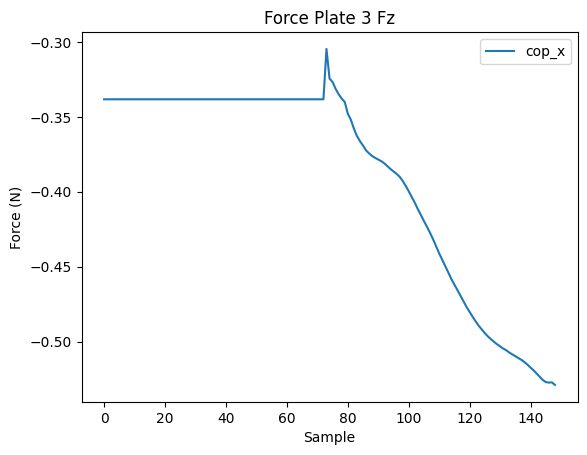

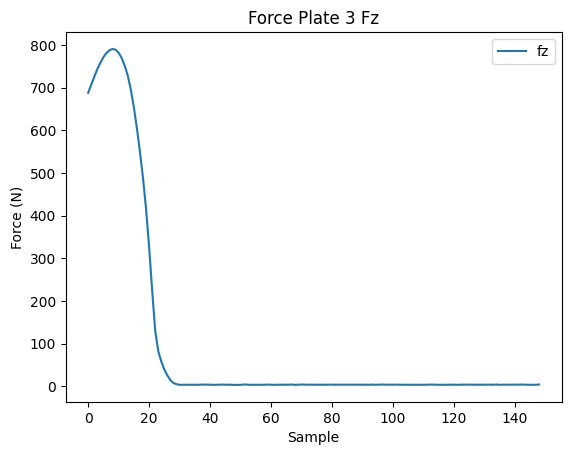

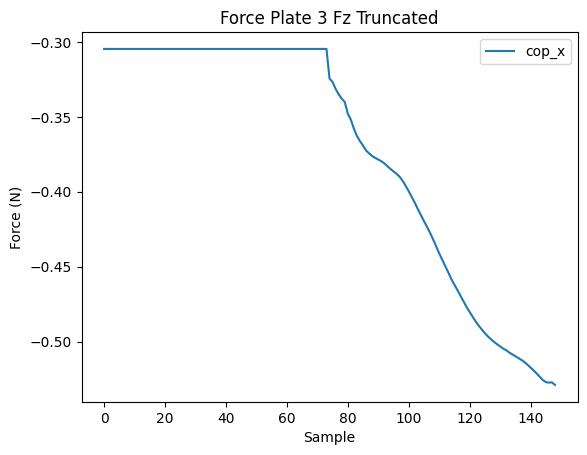

In [9]:
fp1_trunc = fps_trunc[0]
fp2_trunc = fps_trunc[1]
fp3_trunc = fps_trunc[2]

fp1.plot(y=['cop_x'], title='Force Plate 3 Fz', xlabel='Sample', ylabel='Force (N)')
print(len(fp1_trunc), len(fps[1]))

fp1_trunc.plot(y=['cop_x'], title='Force Plate 3 Fz Truncated', xlabel='Sample', ylabel='Force (N)')

In [10]:
def filter_data(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    if cutoff >= nyquist:
        return data
    normalized_cutoff = cutoff / nyquist
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

0      0.255037
1      0.254939
2      0.254621
3      0.253976
4      0.252962
         ...   
144    0.296356
145    0.296356
146    0.296356
147    0.296356
148    0.296356
Name: cop_y, Length: 149, dtype: float64


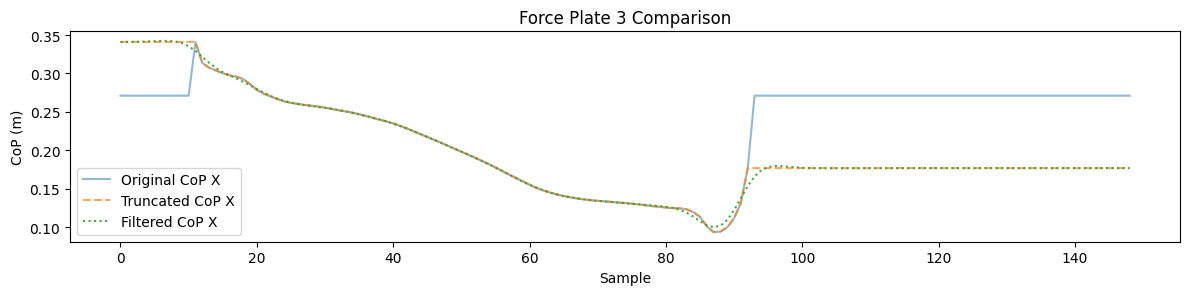

In [11]:
# --- Filter Specifications ---
fc_force = 20   # Hz
fc_cop = 10     # Hz
fs = 100.0  # Hz
order = 2   # Second-order Butterworth filter

# copy truncated data for comparison
fps_filtered = [fp.copy() for fp in fps_trunc]

# Apply filtering to truncated data
for fp in fps_filtered:
    for col in ['fx', 'fy', 'fz']:
        fp[col] = filter_data(fp[col], fc_force, fs, order)
    for col in ['cop_x', 'cop_y']:
        fp[col] = filter_data(fp[col], fc_cop, fs, order)

fp1_filt = fps_filtered[0]
fp2_filt = fps_filtered[1]
fp3_filt = fps_filtered[2]

print(fp2_filt['cop_y'])

# Plot original, truncated, and filtered data for comparison
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(fp2['cop_x'], label='Original CoP X', alpha=0.5)
plt.plot(fp2_trunc['cop_x'], label='Truncated CoP X', alpha=0.7, linestyle='--')
plt.plot(fp2_filt['cop_x'], label='Filtered CoP X', alpha=0.9, linestyle=':')
plt.title('Force Plate 3 Comparison')
plt.xlabel('Sample')
plt.ylabel('CoP (m)')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
time = np.arange(len(fp1)) / fs

# arange dataframe with time, fx, fz, column of 0, cop_x, cop_z for each fps
# store the data with 6 digit precision
def create_output_dataframe(fp, time):

    print(fp)

    output_df = pd.DataFrame({
        'time': time,
        'fx': fp['fx'].round(17),
        'fz': fp['fz'].round(17),
        'zero_col': 0.0,
        'cop_x': fp['cop_x'].round(17),
        'cop_z': fp['cop_z'].round(17)
    })
    return output_df

fp1_output = create_output_dataframe(fp1_filt, time)
fp2_output = create_output_dataframe(fp2_filt, time)
fp3_output = create_output_dataframe(fp3_filt, time)

               fx            fy            fz     cop_x     cop_y  cop_z
0    4.554598e-26  3.783883e-26 -3.577559e-25 -0.304616  0.296996    0.0
1   -1.522895e-25 -7.296203e-26  3.524885e-25 -0.304616  0.296996    0.0
2   -5.199843e-25 -3.309249e-25  2.492190e-24 -0.304616  0.296996    0.0
3   -2.035536e-25 -2.518888e-25  2.902954e-24 -0.304616  0.296996    0.0
4    2.271348e-24  1.214637e-24 -7.249006e-24 -0.304616  0.296996    0.0
..            ...           ...           ...       ...       ...    ...
144 -1.471734e+02 -1.212500e+01  6.068475e+02 -0.524961  0.327905    0.0
145 -1.439389e+02 -1.791946e+01  5.398293e+02 -0.526273  0.328870    0.0
146 -1.366519e+02 -2.065075e+01  4.602771e+02 -0.527309  0.329668    0.0
147 -1.220766e+02 -1.888496e+01  3.657159e+02 -0.528178  0.330315    0.0
148 -1.008988e+02 -1.346226e+01  2.600712e+02 -0.528997  0.330879    0.0

[149 rows x 6 columns]
               fx            fy            fz     cop_x     cop_y  cop_z
0   -5.505895e-04  2.487010

In [13]:
# for 'plank' flag, select samples 50 to 250
if flag == 'plank':
    start_sample = 50
    end_sample = 256
    fp1_output = fp1_output.iloc[start_sample:end_sample].reset_index(drop=True)
    fp2_output = fp2_output.iloc[start_sample:end_sample].reset_index(drop=True)
    fp3_output = fp3_output.iloc[start_sample:end_sample].reset_index(drop=True)

    # reset time column
    fp1_output['time'] = np.arange(len(fp1_output)) / fs
    fp2_output['time'] = np.arange(len(fp2_output)) / fs
    fp3_output['time'] = np.arange(len(fp3_output)) / fs

    print(fp1_output)

In [21]:
# save to txt files with space separator and no index or header
# for 'plank' flag, save as VarForceAppl_001_cut.txt, VarForceAppl_002_cut.txt, VarForceAppl_003_cut.txt
fp1_output.to_csv(f'Dynamic Analysis/{flag}/VarForceAppl_001_cut.txt', sep=' ', index=False, header=False, float_format='%.17f')
# fp2.output.to_csv(f'Dynamic Analysis/{flag}/VarForceAppl_002_cut.txt', sep=' ', index=False, header=False, float_format='%.17f')
fp3_output.to_csv(f'Dynamic Analysis/{flag}/VarForceAppl_002_cut.txt', sep=' ', index=False, header=False, float_format='%.17f')